# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will start with the use of many websites that contains laryngeal Endoscopic Images for Semantic Segmentation. 
The dataset contains will labels which distinguish the area of vocal folds from the hole image (just 2 classes : vocal folds and background). 

![alt text](https://github.com/Houssem96/Unet/blob/master/data.PNG?raw=true)

We have uploaded it drive to use it later for training the model  

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'/content/drive/My Drive/my_data/annotations/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'/content/drive/My Drive/my_data/images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 15
all_files = os.listdir('/content/drive/My Drive/my_data/annotations/')
shuffle(all_files)

split = int(0.90 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [0]:
print("Here We go !!!")

Here We go !!!


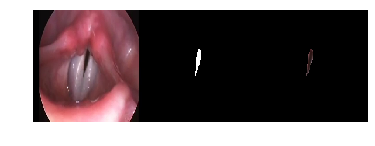

In [0]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = Adam(lr=1e-04), loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [0]:
model = unet()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'/content/drive/My Drive/my_data/images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

9
1



i= 1 loss= 0.6665338277816772 val_loss= 0.6554275155067444 mean_iou= 0.01391213348445793 val_mean_iou= 0.00027941842563450336


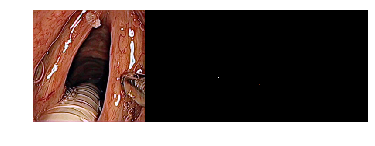

i= 2 loss= 0.6454286509089999 val_loss= 0.6330397129058838 mean_iou= 2.0243702389658818e-05 val_mean_iou= 0.0


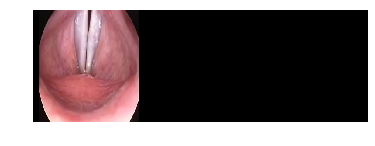

i= 3 loss= 0.616024825308058 val_loss= 0.6047230958938599 mean_iou= 0.0 val_mean_iou= 0.0


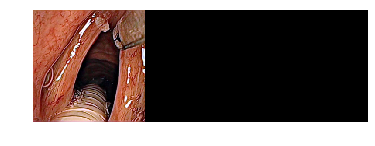

i= 4 loss= 0.5864759617381625 val_loss= 0.5722659826278687 mean_iou= 0.0 val_mean_iou= 0.0


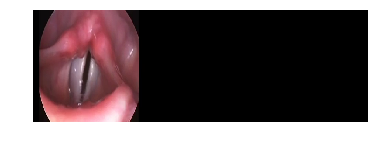

i= 5 loss= 0.5528068741162618 val_loss= 0.5377734899520874 mean_iou= 0.0 val_mean_iou= 0.0


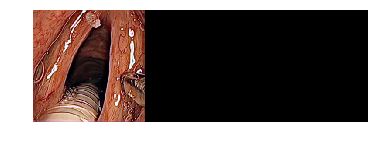

i= 6 loss= 0.5088257027996911 val_loss= 0.5126368403434753 mean_iou= 0.0 val_mean_iou= 0.0


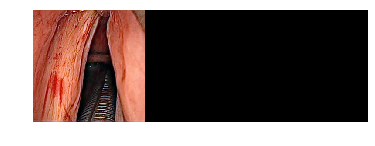

i= 7 loss= 0.4519079393810696 val_loss= 0.4333949387073517 mean_iou= 0.0 val_mean_iou= 0.0


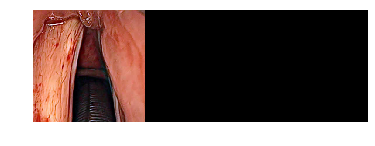

i= 8 loss= 0.3932824863327874 val_loss= 0.3114545941352844 mean_iou= 0.0 val_mean_iou= 0.0


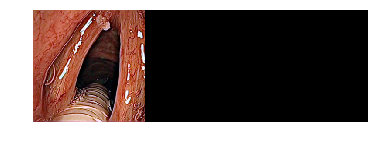

i= 9 loss= 0.3243519001536899 val_loss= 0.291349321603775 mean_iou= 0.0 val_mean_iou= 0.0


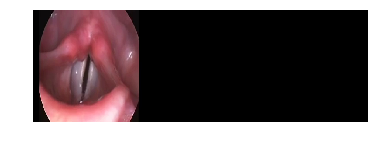

i= 10 loss= 0.2744554215007358 val_loss= 0.2565412223339081 mean_iou= 0.0 val_mean_iou= 0.0


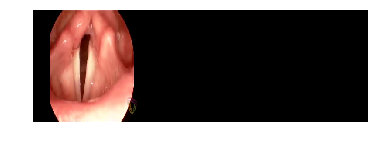

i= 11 loss= 0.26447995834880406 val_loss= 0.24048377573490143 mean_iou= 0.0 val_mean_iou= 0.0


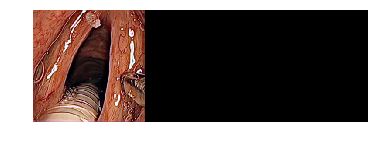

i= 12 loss= 0.2758786314063602 val_loss= 0.2579917907714844 mean_iou= 0.0 val_mean_iou= 0.0


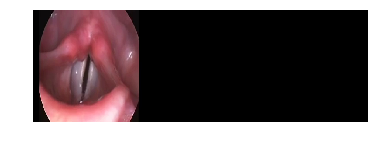

i= 13 loss= 0.25145602060688865 val_loss= 0.22318114340305328 mean_iou= 0.0 val_mean_iou= 0.0


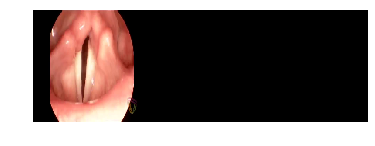

i= 14 loss= 0.22569940156406826 val_loss= 0.27181169390678406 mean_iou= 0.0 val_mean_iou= 0.0


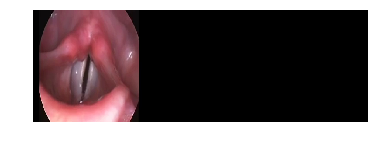

i= 15 loss= 0.23274855646822187 val_loss= 0.19706487655639648 mean_iou= 0.0 val_mean_iou= 0.0


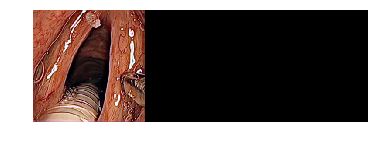

i= 16 loss= 0.20274520251486036 val_loss= 0.15323108434677124 mean_iou= 0.0 val_mean_iou= 0.0


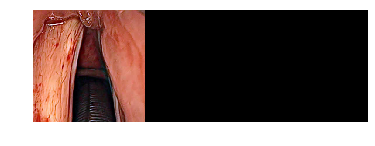

i= 17 loss= 0.1816465606292089 val_loss= 0.1171107292175293 mean_iou= 0.0 val_mean_iou= 0.0


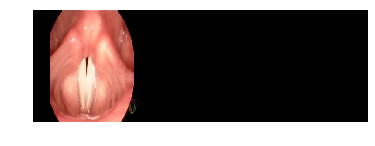

i= 18 loss= 0.19828437765439352 val_loss= 0.15328241884708405 mean_iou= 0.0 val_mean_iou= 0.0


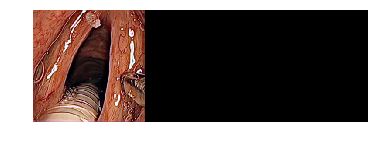

i= 19 loss= 0.19873559640513527 val_loss= 0.17413590848445892 mean_iou= 0.0 val_mean_iou= 0.0


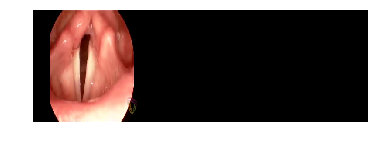

i= 20 loss= 0.15586056808630624 val_loss= 0.15148156881332397 mean_iou= 0.0 val_mean_iou= 0.0


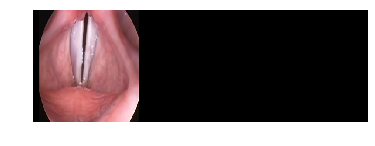

i= 21 loss= 0.1913340778814422 val_loss= 0.12401512265205383 mean_iou= 0.0 val_mean_iou= 0.0


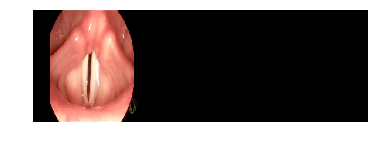

i= 22 loss= 0.1676080028216044 val_loss= 0.1501961052417755 mean_iou= 0.0 val_mean_iou= 0.0


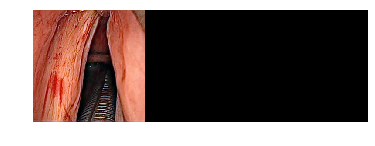

i= 23 loss= 0.164930553899871 val_loss= 0.14784392714500427 mean_iou= 0.0 val_mean_iou= 0.0


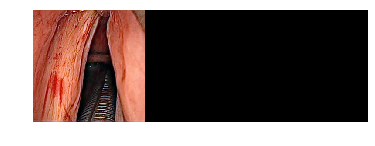

i= 24 loss= 0.15421727879179847 val_loss= 0.14318133890628815 mean_iou= 0.0 val_mean_iou= 0.0


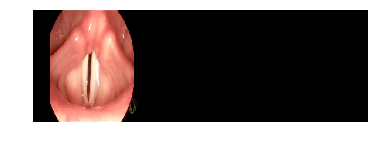

i= 25 loss= 0.15247482972012627 val_loss= 0.12898172438144684 mean_iou= 0.0 val_mean_iou= 0.0


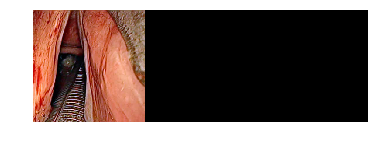

i= 26 loss= 0.15186933014127943 val_loss= 0.09943921118974686 mean_iou= 0.0 val_mean_iou= 0.0


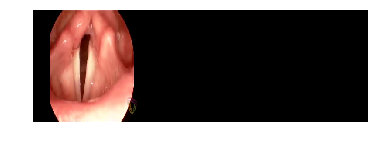

i= 27 loss= 0.14152123944626915 val_loss= 0.13229812681674957 mean_iou= 1.8902555893873796e-06 val_mean_iou= 1.8095781342708506e-05


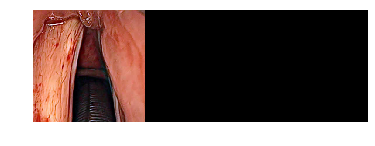

i= 28 loss= 0.1454172374473678 val_loss= 0.08681289106607437 mean_iou= 4.602397904010205e-05 val_mean_iou= 0.0010783661855384707


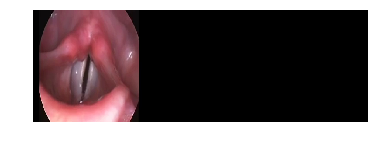

i= 29 loss= 0.12684494588110182 val_loss= 0.14529940485954285 mean_iou= 0.0026994888580197263 val_mean_iou= 0.022808194160461426


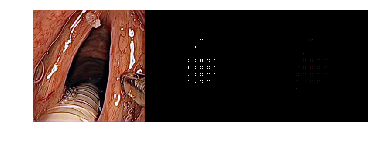

i= 30 loss= 0.1284244739347034 val_loss= 0.149516299366951 mean_iou= 0.03195639637609323 val_mean_iou= 0.05062020942568779


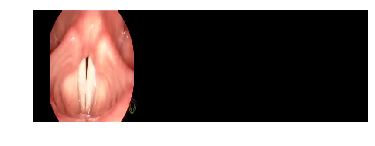

i= 31 loss= 0.11432444635364744 val_loss= 0.12160619348287582 mean_iou= 0.07186521672540241 val_mean_iou= 0.09431403130292892


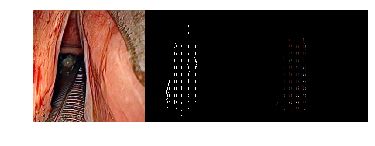

i= 32 loss= 0.09932003915309906 val_loss= 0.06813282519578934 mean_iou= 0.11488254368305206 val_mean_iou= 0.2459552139043808


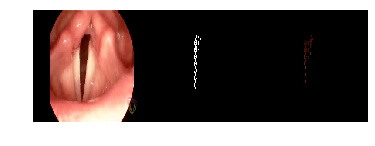

i= 33 loss= 0.10891423622767131 val_loss= 0.09055432677268982 mean_iou= 0.35788755781120724 val_mean_iou= 0.502000093460083


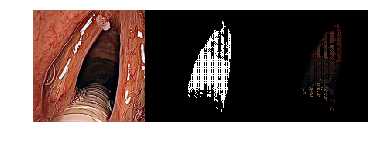

i= 34 loss= 0.12174522380034129 val_loss= 0.09650745987892151 mean_iou= 0.5378731555408902 val_mean_iou= 0.7498233914375305


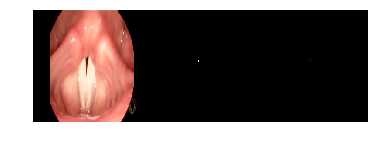

i= 35 loss= 0.1004152645667394 val_loss= 0.061041370034217834 mean_iou= 0.6762567493650649 val_mean_iou= 0.8323602080345154


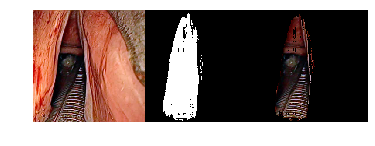

i= 36 loss= 0.11714837037854725 val_loss= 0.11696172505617142 mean_iou= 0.7596925099690756 val_mean_iou= 0.8579035997390747


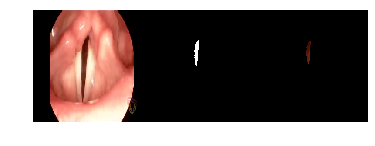

i= 37 loss= 0.09997870648900668 val_loss= 0.07208552211523056 mean_iou= 0.7560650706291199 val_mean_iou= 0.7836272716522217


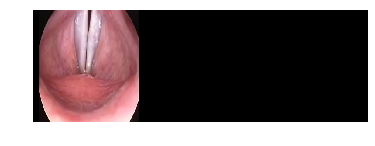

i= 38 loss= 0.07397261551684803 val_loss= 0.035780295729637146 mean_iou= 0.7761435442500644 val_mean_iou= 0.8212316036224365


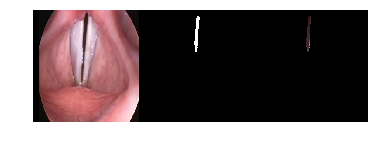

i= 39 loss= 0.07289414977033933 val_loss= 0.08031488955020905 mean_iou= 0.7358182403776381 val_mean_iou= 0.7776982188224792


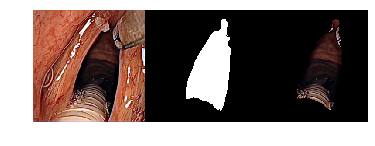

i= 40 loss= 0.08833054370350307 val_loss= 0.08760897815227509 mean_iou= 0.7821698321236504 val_mean_iou= 0.7643796801567078


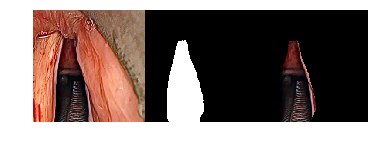

i= 41 loss= 0.08116092781225841 val_loss= 0.0763883888721466 mean_iou= 0.7375027305550046 val_mean_iou= 0.7861730456352234


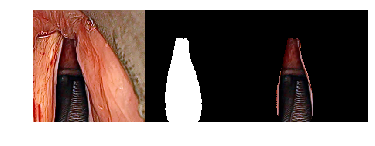

i= 42 loss= 0.06490551514758004 val_loss= 0.05310848727822304 mean_iou= 0.7754856414265103 val_mean_iou= 0.8445789217948914


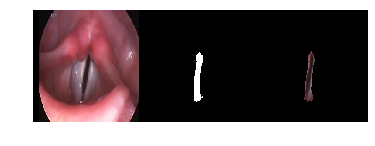

i= 43 loss= 0.05409103425012694 val_loss= 0.049000758677721024 mean_iou= 0.8079403969976637 val_mean_iou= 0.8647322058677673


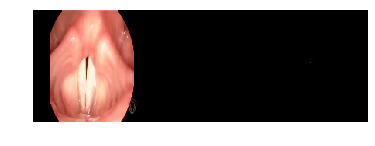

i= 44 loss= 0.04990943811006016 val_loss= 0.04147690162062645 mean_iou= 0.8326334357261658 val_mean_iou= 0.8606927990913391


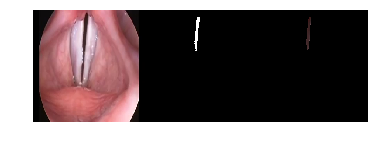

i= 45 loss= 0.04818280372354719 val_loss= 0.05243268236517906 mean_iou= 0.8085259993871053 val_mean_iou= 0.8193984627723694


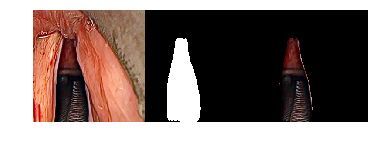

i= 46 loss= 0.054604068812396794 val_loss= 0.040476761758327484 mean_iou= 0.7972073488765292 val_mean_iou= 0.834611713886261


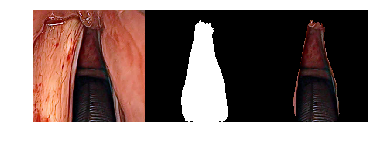

i= 47 loss= 0.04571501724421978 val_loss= 0.03254568204283714 mean_iou= 0.8387829065322876 val_mean_iou= 0.857753336429596


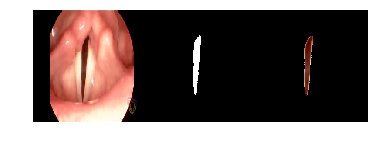

i= 48 loss= 0.041363285233577095 val_loss= 0.04080178588628769 mean_iou= 0.8254542483223809 val_mean_iou= 0.8509956002235413


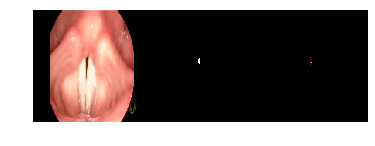

i= 49 loss= 0.041651837734712496 val_loss= 0.027661334723234177 mean_iou= 0.846198214424981 val_mean_iou= 0.8807058930397034


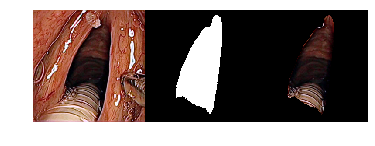

i= 50 loss= 0.0425153144945701 val_loss= 0.030016230419278145 mean_iou= 0.8368857238027785 val_mean_iou= 0.8870647549629211


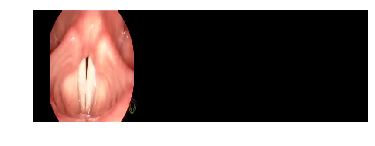

i= 51 loss= 0.039787687775161534 val_loss= 0.03376384079456329 mean_iou= 0.8719155523512099 val_mean_iou= 0.87457674741745


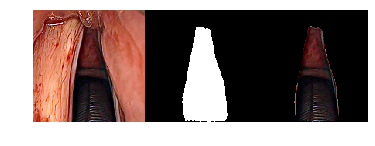

i= 52 loss= 0.042333872988820076 val_loss= 0.03663598746061325 mean_iou= 0.8593516018655565 val_mean_iou= 0.8907617926597595


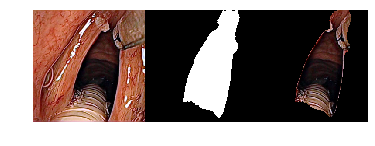

i= 53 loss= 0.035053842390576996 val_loss= 0.0340849906206131 mean_iou= 0.8693214456240336 val_mean_iou= 0.8715101480484009


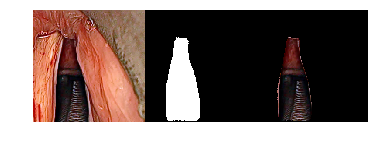

i= 54 loss= 0.03701598714623186 val_loss= 0.044436145573854446 mean_iou= 0.8666581710179647 val_mean_iou= 0.8735336065292358


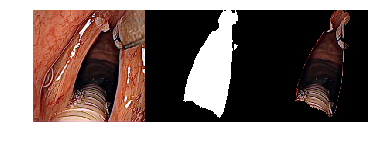

i= 55 loss= 0.03256232084499465 val_loss= 0.0440531000494957 mean_iou= 0.8764863610267639 val_mean_iou= 0.833418607711792


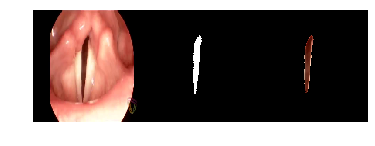

i= 56 loss= 0.03886782336566183 val_loss= 0.042467910796403885 mean_iou= 0.8388035496075948 val_mean_iou= 0.8939997553825378


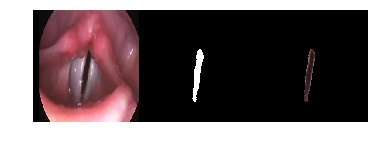

i= 57 loss= 0.03579801134765148 val_loss= 0.040529489517211914 mean_iou= 0.8464028835296631 val_mean_iou= 0.8881596326828003


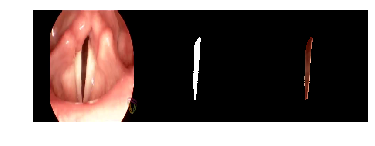

i= 58 loss= 0.034432022728853755 val_loss= 0.029958132654428482 mean_iou= 0.8786188695165846 val_mean_iou= 0.8861976265907288


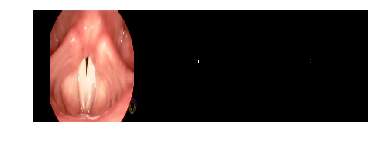

i= 59 loss= 0.03616358877884017 val_loss= 0.038938965648412704 mean_iou= 0.8663318223423428 val_mean_iou= 0.8895416855812073


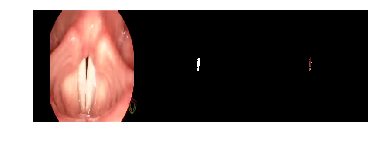

i= 60 loss= 0.03242345920039548 val_loss= 0.03344828262925148 mean_iou= 0.8864243295457628 val_mean_iou= 0.8776549696922302


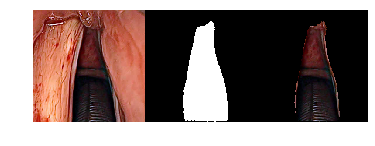

i= 61 loss= 0.03261000456081496 val_loss= 0.035680510103702545 mean_iou= 0.8646459910604689 val_mean_iou= 0.9070045351982117


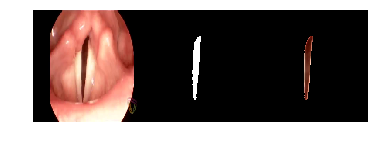

i= 62 loss= 0.033145308701528445 val_loss= 0.035163480788469315 mean_iou= 0.8590944210688273 val_mean_iou= 0.865986168384552


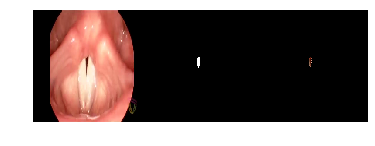

i= 63 loss= 0.03271894632942147 val_loss= 0.04012506827712059 mean_iou= 0.8804777595731947 val_mean_iou= 0.8626104593276978


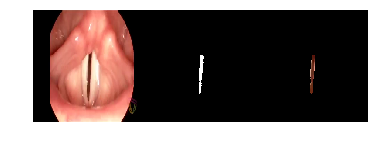

i= 64 loss= 0.036818252669440374 val_loss= 0.025795098394155502 mean_iou= 0.8435884316762289 val_mean_iou= 0.8786607980728149


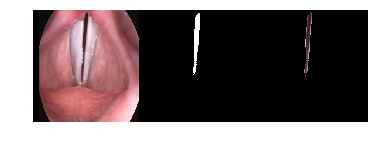

i= 65 loss= 0.033921781099504895 val_loss= 0.03293834999203682 mean_iou= 0.8737089700169034 val_mean_iou= 0.8734970092773438


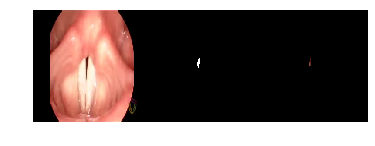

i= 66 loss= 0.03018102939758036 val_loss= 0.041931215673685074 mean_iou= 0.8886169261402554 val_mean_iou= 0.8767185211181641


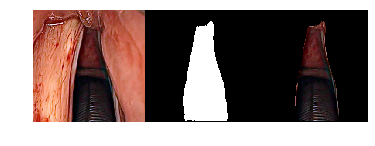

i= 67 loss= 0.029593367957406573 val_loss= 0.03844946250319481 mean_iou= 0.8903794818454318 val_mean_iou= 0.847906768321991


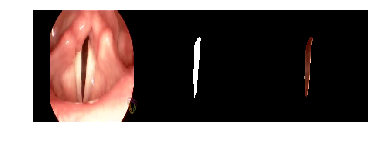

i= 68 loss= 0.03100333424905936 val_loss= 0.029337631538510323 mean_iou= 0.880176842212677 val_mean_iou= 0.880506157875061


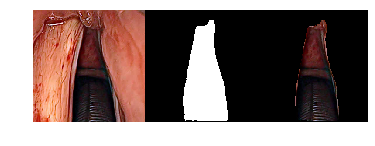

i= 69 loss= 0.025515288528468873 val_loss= 0.03139467164874077 mean_iou= 0.9139092697037591 val_mean_iou= 0.8767974376678467


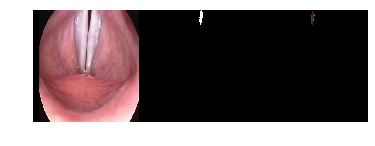

i= 70 loss= 0.024225534664260015 val_loss= 0.029573652893304825 mean_iou= 0.8898155887921652 val_mean_iou= 0.8836538791656494


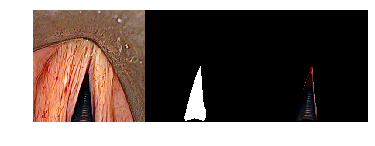

i= 71 loss= 0.031516954509748354 val_loss= 0.017187343910336494 mean_iou= 0.9111027320226034 val_mean_iou= 0.8570769429206848


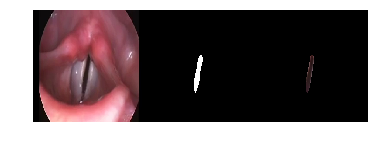

i= 72 loss= 0.026998049683041044 val_loss= 0.03815390169620514 mean_iou= 0.8830704026752048 val_mean_iou= 0.869586706161499


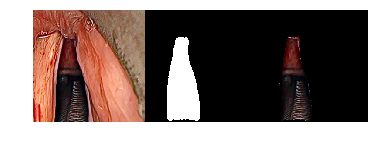

i= 73 loss= 0.027395661506387923 val_loss= 0.032500170171260834 mean_iou= 0.911691301398807 val_mean_iou= 0.8529047966003418


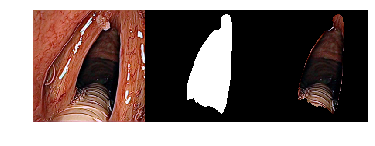

i= 74 loss= 0.02580709858900971 val_loss= 0.034096162766218185 mean_iou= 0.8998428781827291 val_mean_iou= 0.8875735402107239


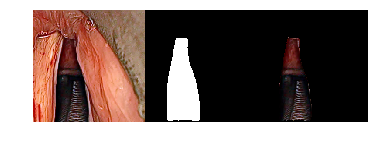

i= 75 loss= 0.02590765907532639 val_loss= 0.027448033913969994 mean_iou= 0.8911256459024217 val_mean_iou= 0.8696022629737854


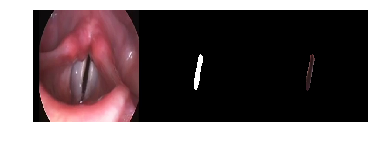

i= 76 loss= 0.026131074668632612 val_loss= 0.04347173869609833 mean_iou= 0.9032039311197069 val_mean_iou= 0.8750827312469482


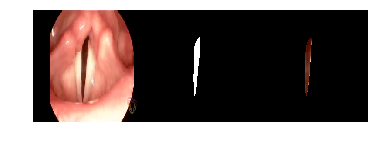

i= 77 loss= 0.025019725577698812 val_loss= 0.0347188301384449 mean_iou= 0.8952235844400194 val_mean_iou= 0.8931151032447815


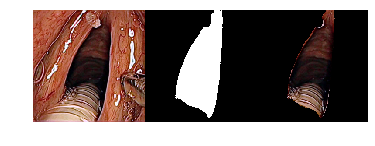

i= 78 loss= 0.020879361054135695 val_loss= 0.04518916457891464 mean_iou= 0.8980595469474792 val_mean_iou= 0.8932167291641235


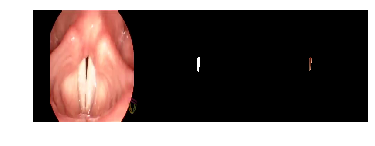

i= 79 loss= 0.02523658921321233 val_loss= 0.03304357826709747 mean_iou= 0.8902115888065762 val_mean_iou= 0.883825957775116


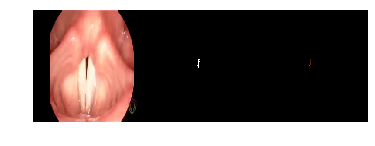

i= 80 loss= 0.024210179017649755 val_loss= 0.03528786450624466 mean_iou= 0.9097062216864692 val_mean_iou= 0.8944958448410034


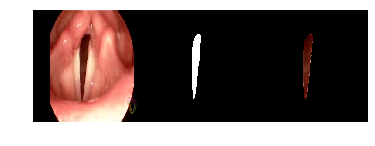

i= 81 loss= 0.023800881786478892 val_loss= 0.029816389083862305 mean_iou= 0.8977775110138787 val_mean_iou= 0.8838279247283936


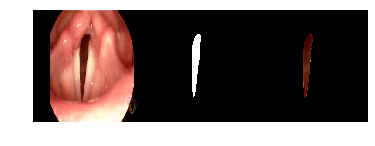

i= 82 loss= 0.024727509460515447 val_loss= 0.026958059519529343 mean_iou= 0.9087598125139872 val_mean_iou= 0.876105546951294


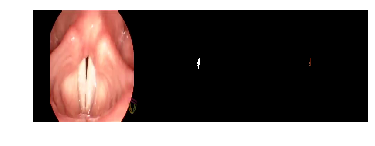

i= 83 loss= 0.022534316612614527 val_loss= 0.039798371493816376 mean_iou= 0.9059723681873746 val_mean_iou= 0.8796568512916565


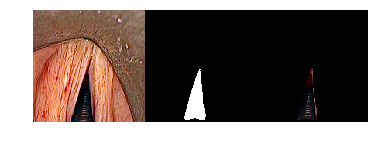

i= 84 loss= 0.02379131896628274 val_loss= 0.04334747791290283 mean_iou= 0.8971081574757894 val_mean_iou= 0.8806306719779968


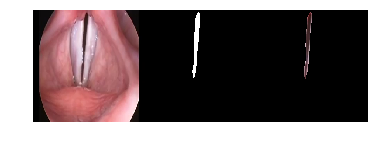

i= 85 loss= 0.0197639140403933 val_loss= 0.03331868350505829 mean_iou= 0.9211124115520053 val_mean_iou= 0.8962130546569824


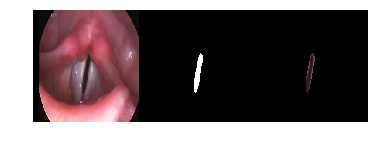

i= 86 loss= 0.02039984210083882 val_loss= 0.022154271602630615 mean_iou= 0.9209002322620816 val_mean_iou= 0.8942331075668335


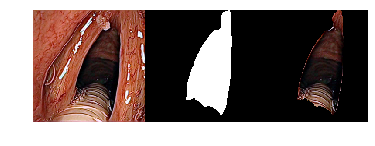

i= 87 loss= 0.020836496932639018 val_loss= 0.054101355373859406 mean_iou= 0.9171001977390714 val_mean_iou= 0.8594264388084412


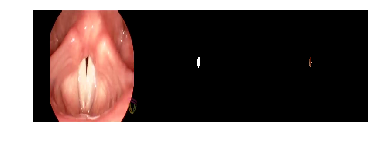

i= 88 loss= 0.020139191403157182 val_loss= 0.022443192079663277 mean_iou= 0.9198595020506117 val_mean_iou= 0.8549050688743591


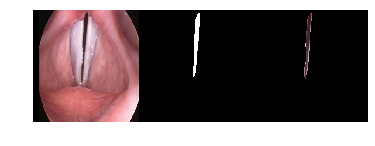

i= 89 loss= 0.018827069757713213 val_loss= 0.041608069092035294 mean_iou= 0.9159201913409762 val_mean_iou= 0.8936964273452759


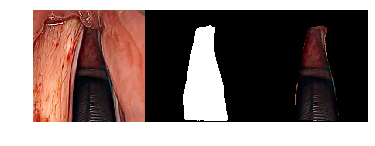

i= 90 loss= 0.02070849037004842 val_loss= 0.03242046386003494 mean_iou= 0.9068203237321641 val_mean_iou= 0.8988397717475891


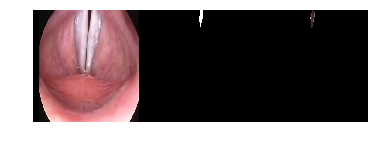

i= 91 loss= 0.02197763541092475 val_loss= 0.030135463923215866 mean_iou= 0.910825252532959 val_mean_iou= 0.8922978043556213


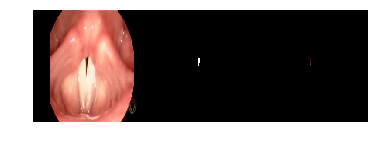

i= 92 loss= 0.02032704320218828 val_loss= 0.047394976019859314 mean_iou= 0.9282629357443916 val_mean_iou= 0.8848127126693726


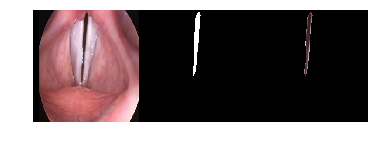

i= 93 loss= 0.021216010881794825 val_loss= 0.017726564779877663 mean_iou= 0.9219125575489469 val_mean_iou= 0.8540595173835754


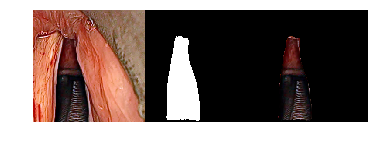

i= 94 loss= 0.01842590079953273 val_loss= 0.02955351024866104 mean_iou= 0.9230448537402682 val_mean_iou= 0.8639532327651978


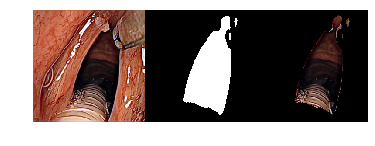

i= 95 loss= 0.020040820870134566 val_loss= 0.03091815486550331 mean_iou= 0.9288758105701871 val_mean_iou= 0.8707521557807922


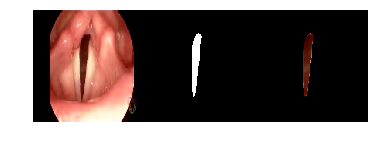

i= 96 loss= 0.01912467512819502 val_loss= 0.02552027255296707 mean_iou= 0.9202558596928915 val_mean_iou= 0.8991827368736267


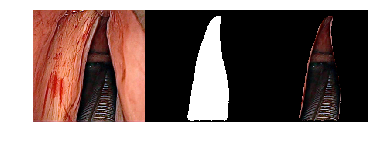

i= 97 loss= 0.018682268137733143 val_loss= 0.05264950543642044 mean_iou= 0.937727861934238 val_mean_iou= 0.8806977868080139


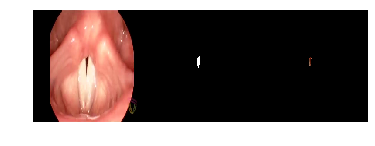

i= 98 loss= 0.018680800476835832 val_loss= 0.03500927984714508 mean_iou= 0.9229857325553894 val_mean_iou= 0.8892369270324707


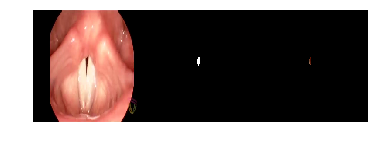

i= 99 loss= 0.02167573333200481 val_loss= 0.05705542489886284 mean_iou= 0.926508989599016 val_mean_iou= 0.891362190246582


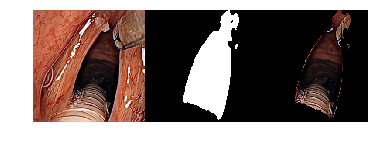

i= 100 loss= 0.023159147033260927 val_loss= 0.04420351982116699 mean_iou= 0.9037383993466696 val_mean_iou= 0.8808979392051697


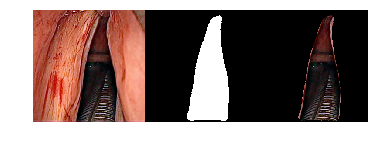

In [0]:
model.fit_generator(train_generator, 
                    epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

**Makinig our SVM classifier from some previous sequences**

In [0]:
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
# reading csv file and extracting class column to y. 
data = pd.read_csv('/content/drive/My Drive/svm_dataset.csv') 
x=data[['img1','img2','img3','img4','img5','img6','img7','img8','img9','img10']]
y=data[['classe']]
# Split data to train and test on 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)
# Create a linear SVM classifier 
clf = svm.SVC(kernel='rbf', C = 10.0, gamma=0.1)
# Train classifier 
clf.fit(X_train, y_train)
# Make predictions on unseen test data
clf_predictions = clf.predict(X_test)
print("Accuracy: {}%".format(clf.score(X_test, y_test) * 100 ))

Accuracy: 100.0%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Testing

Saving 112.PNG to 112.PNG
Saving 114.PNG to 114.PNG
Saving 116.PNG to 116.PNG
Saving 118.PNG to 118.PNG
Saving 119.PNG to 119.PNG
Saving 120.PNG to 120.PNG
Saving 121.PNG to 121.PNG
Saving 122.PNG to 122.PNG
Saving 123.PNG to 123.PNG
Saving 124.PNG to 124.PNG


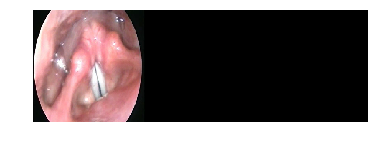

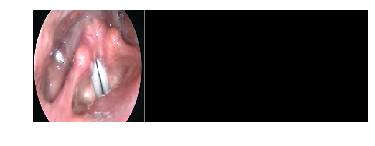

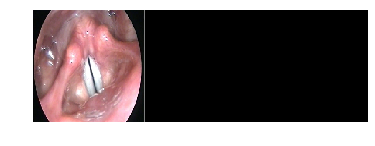

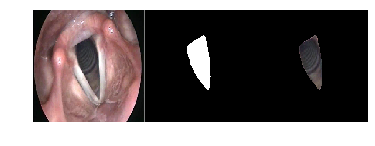

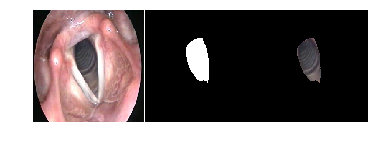

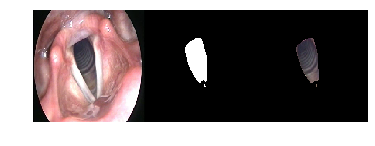

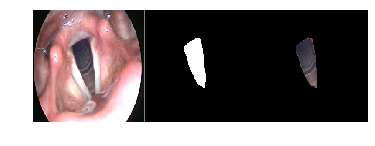

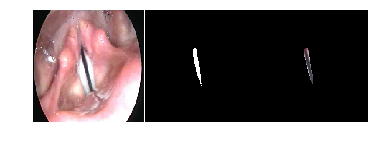

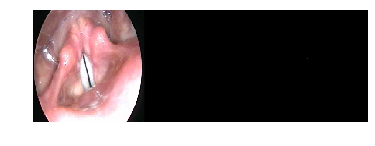

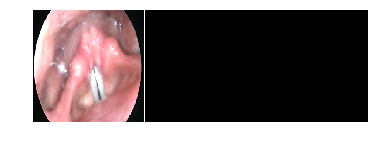

[0.0, 0.0, 0.0, 1.0, 0.9513513513513514, 0.8846063454759107, 0.8333725029377204, 0.16333725029377202, 0.0009400705052878966, 0.0]
this person has a normal vocal folds condition


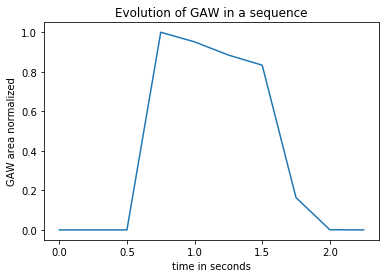

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
GAW=[]

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  raw = np.array(img.resize((256, 256)))/255.
  raw = raw[:,:,0:3]

  #predict the mask 
  pred = model.predict(np.expand_dims(raw, 0))

  #mask post-processing 
  msk  = pred.squeeze()
  msk = np.stack((msk,)*3, axis=-1)
  msk[msk >= 0.5] = 1 
  msk[msk < 0.5] = 0 

  #show the mask and the segmented image 
  combined = np.concatenate([raw, msk, raw* msk], axis = 1)
  plt.axis('off')
  plt.imshow(combined)
  plt.show()
  #Calculating the glotal area waveform GAW from image mask
  GAW.append(np.count_nonzero(msk))
m=max(GAW)
GAW = [i/m for i in GAW]
print(GAW)
time=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25]
plt.plot(time,GAW)
plt.title('Evolution of GAW in a sequence')
plt.xlabel('time in seconds')
plt.ylabel('GAW area normalized')
GAW=pd.DataFrame(GAW)
#Predicting the class of the sequence of images : healthy conditions / pathology
res=clf.predict(GAW.transpose())
if(res[0]):
  print('this person has a normal vocal folds condition')
else:
  print('this person has a problem !!!')


In [0]:
#saving the model to use it other time without retraining it again
model.save_weights("/content/drive/My Drive/MyUNetModel.h5")

# Next steps ...

In [0]:
#Printing the model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 8)  584         conv2d_55[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_56[0][0]                  
____________________________________________________________________________________________

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

